In [21]:
import numpy as np
import pandas as pd
from scipy import stats
from laspy.file import File
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go

%matplotlib notebook

In [22]:
file_dir = '../../Data/parking_lot/'
filenames =[
#             '10552_NYU_M2 - Scanner 1 - 190511_164039_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_164239_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_164445_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_172558_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_172753_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_172928_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_180428_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_180632_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_180819_1 - originalpoints.laz',
#             '10552_NYU_M3 - Scanner 1 - 190511_200348_1 - originalpoints.laz',
#             '10552_NYU_M3 - Scanner 1 - 190511_200600_1 - originalpoints.laz',
#             '10552_NYU_M3 - Scanner 1 - 190511_200742_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_163824_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_164640_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_172416_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_173110_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_164845_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_172201_1 - originalpoints.laz',
#             '10552_NYU_M2 - Scanner 1 - 190511_173238_1 - originalpoints.laz',
    '10552_NYU_M3 - Scanner 1 - 190511_200938_1 - originalpoints.laz',
    '10552_NYU_M3 - Scanner 1 - 190511_200212_1 - originalpoints.laz',
    '10552_NYU_M2 - Scanner 1 - 190511_181004_1 - originalpoints.laz',
    '10552_NYU_M2 - Scanner 1 - 190511_180231_1 - originalpoints.laz'
]

columns_point_cloud = [
    'X','Y','Z',
    'intensity',
    'flag_byte',
    'classification_flags',
    'classification_byte',
    'user_data',
    'scan_angle',
    'pt_src_id',
    'gps_time']

In [23]:
def raw_to_df(raw,column_names):
    '''function takes raw output of laspy.File.get_points() and column names, and returns a pandas Dataframe'''
    raw_list = [a[0].tolist() for a in raw]
    df = pd.DataFrame(raw_list,columns = column_names)
    return df

def scale_and_offset(df,header,append_to_df=False):
    '''Function takes as input the dataframe output of raw_to_df and the laspy header file.
       Output is a nx3 dataframe with adjusted X,Y, and Z coordinates, from the formula: 
       X_adj = X*X_scale + X_offset.
       Brooklyn LiDAR readings appear to be in feet, and use NAVD 88 in the vertical and 
       New York Long Island State Plane Coordinate System NAD 33 in the horizontal.'''
    offset = header.offset
    scale = header.scale
    scaled_xyz = df[['X','Y','Z']]*scale + offset
    if append_to_df:
        df['x_scaled'] = scaled_xyz['X']
        df['y_scaled'] = scaled_xyz['Y']
        df['z_scaled'] = scaled_xyz['Z'] 
        return df
    else:
        return scaled_xyz

def create_df_pickle(file_dir,filename,column_names):
    inFile = File(file_dir+filename, mode='r')
    raw = inFile.get_points()
    df = raw_to_df(raw,column_names)
    df = scale_and_offset(df,inFile.header,append_to_df=True)
    pickle_name = 'las_points_'+filename[34:40]+'.pkl'
    df.to_pickle(file_dir + pickle_name)

## Flat surface
Identifying points in a parking lot to assess how consistently flat they are.  
Center point: 40.645789, -74.025951  
Easting - 977048.434  
Northing - 174555.792

In [ ]:
# This works
for filename in filenames:
    create_df_pickle(file_dir,filename,columns_point_cloud)

In [24]:
# Extract points within a square around the desired point
pt_x = 977037.343
pt_y = 174586.034
feet_from_point = 5
size_of_square = (2*feet_from_point)**2

# For plot of points from scan
pts_from_scan = []

square_points = pd.DataFrame()

# Load pickle, extract points around square, iterate
for pick in [#'las_points_164845.pkl',
#              'las_points_164640.pkl',
#              'las_points_164445.pkl',
#              'las_points_164239.pkl',
#              'las_points_164039.pkl',
#              'las_points_163824.pkl',
#              'las_points_173238.pkl',
#              'las_points_173110.pkl',
#              'las_points_172928.pkl',
#              'las_points_172753.pkl',
#              'las_points_172558.pkl',
#              'las_points_172416.pkl',
#              'las_points_172201.pkl',
#              'las_points_180819.pkl',
#              'las_points_180632.pkl',
#              'las_points_180428.pkl',
#              'las_points_200742.pkl',
#              'las_points_200600.pkl',
             'las_points_200348.pkl',
#              'las_points_180231.pkl',
#              'las_points_181004.pkl',
#              'las_points_200938.pkl',
#              'las_points_200212.pkl',
            ]:
    las_points = pd.read_pickle(file_dir+pick)
    
    new_square_points = las_points[ (las_points['x_scaled'] < pt_x + feet_from_point)
            &(las_points['x_scaled'] > pt_x - feet_from_point) 
            &(las_points['y_scaled'] < pt_y + feet_from_point)
            &(las_points['y_scaled'] > pt_y - feet_from_point)
          ]
    print("Point count in new square from {:s}: {:d}".format(pick,new_square_points.shape[0]))
    pts_from_scan.append((pick,new_square_points.shape[0]))
    square_points = square_points.append(new_square_points,sort=True)

print("Total point count in square: {:d}".format(square_points.shape[0]))
print("Size of square: {:2.2f} sq ft".format(size_of_square))
print("Point density: {:2.2f} points / sq ft".format(square_points.shape[0]/size_of_square))

Point count in new square from las_points_200348.pkl: 518
Total point count in square: 518
Size of square: 100.00 sq ft
Point density: 5.18 points / sq ft


Text(0.5, 0, 'Run ID')

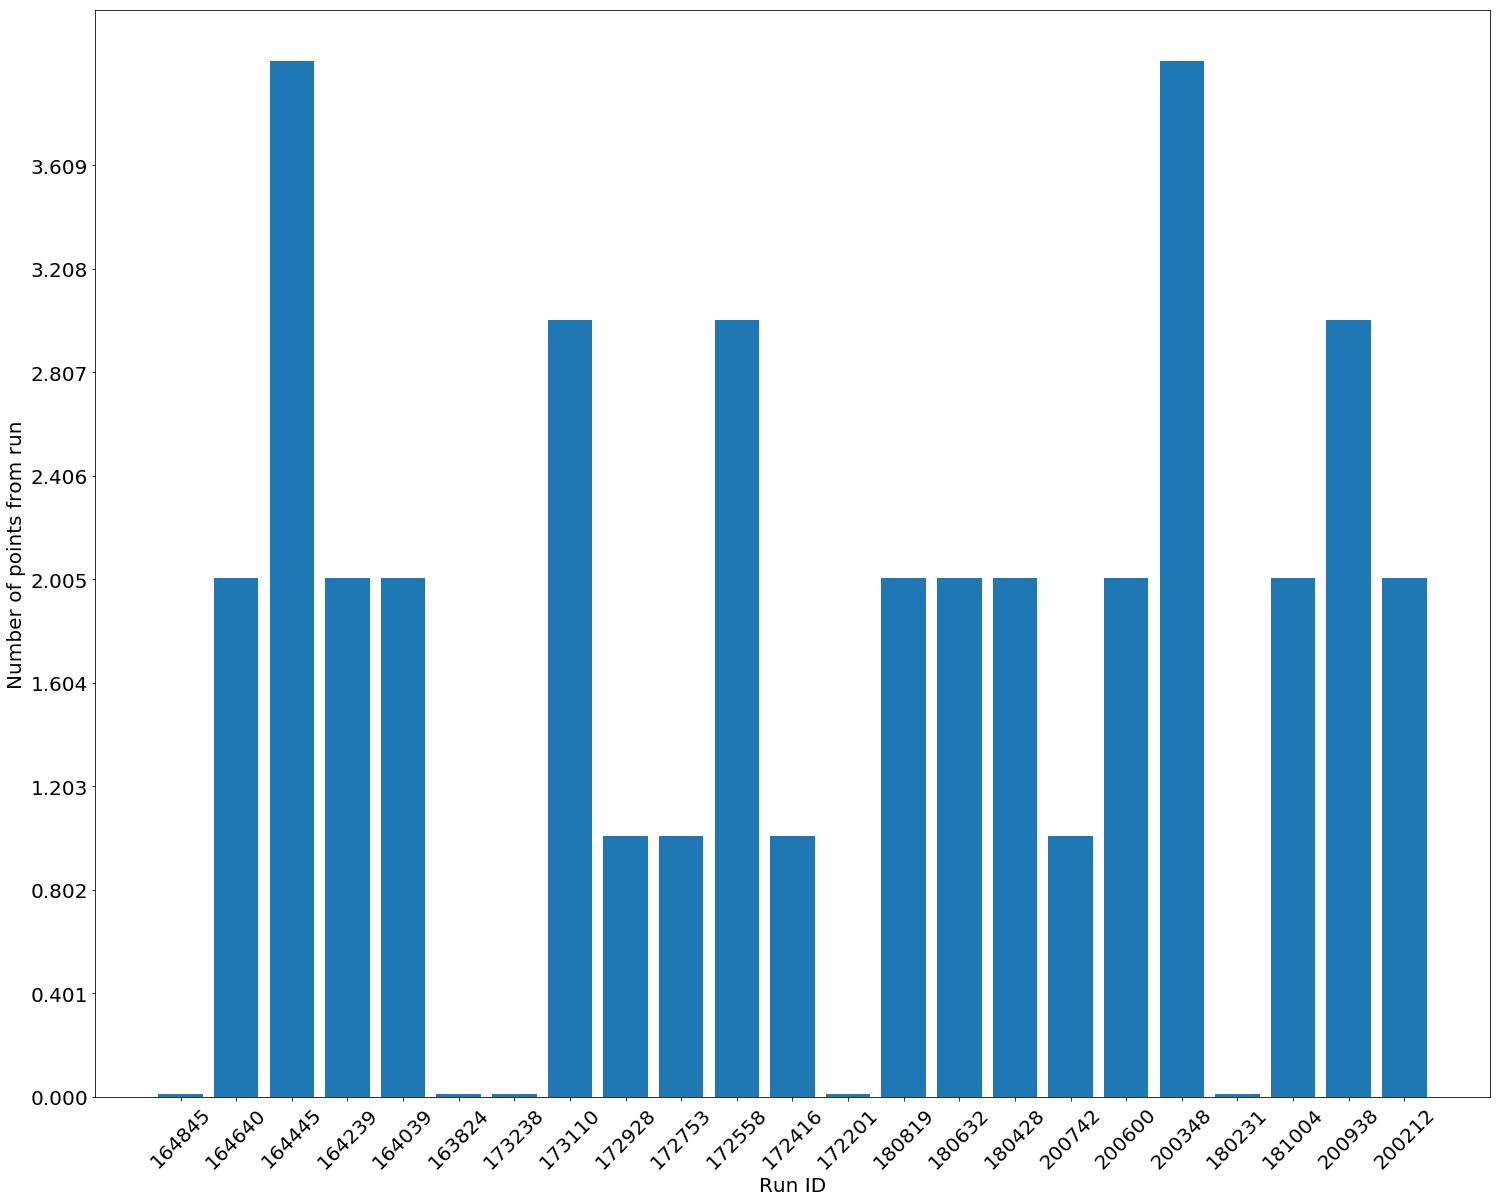

In [5]:
labels = [pt[0][11:-4] for pt in pts_from_scan]
num_points = [pt[1]+.01 for pt in pts_from_scan]
plt.figure(figsize=(25,20))
plt.bar(labels,num_points,)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(np.arange(0, max(num_points), step=(max(num_points)/10)),fontsize=20)
plt.ylabel("Number of points from run",fontsize=20)
plt.xlabel("Run ID",fontsize=20)

In [ ]:
labels[0][11:-4]

In [14]:
# fit a plane to square_points via SVD
def plane_fit(square_points):
    raw_points = np.array(square_points[['x_scaled','y_scaled','z_scaled']]).T
    points = raw_points.T - raw_points.mean(axis=1)
    svd = np.linalg.svd(points.T)
    norm_vector = np.transpose(svd[0])[2]    
    # Calculate each point's distance from the plane
    dist_from_plane = [np.dot(point,norm_vector) for point in points]

    square_points['dist_from_plane'] = dist_from_plane
    return norm_vector,points,square_points
norm_vector,points,square_points = plane_fit(square_points)

# Add distance from flat plane with norm (x,y,z) = (0,0,1)
square_points['dist_from_flat']=np.array([np.dot(point,np.array([0,0,1])) for point in points])

# remove data points >5 feet below plane.
outliers = square_points[square_points['dist_from_plane']<-5].index
square_points = square_points.drop(outliers)


In [ ]:
# How do I make the dots smaller?
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=(square_points['x_scaled']-square_points['x_scaled'].min()), 
                                   y=(square_points['y_scaled']-square_points['y_scaled'].min()),  
                                   z=(square_points['z_scaled']-square_points['z_scaled'].mean()), 
                                   mode='markers',
                                  marker=dict(size=4,
                                              color=2))])

fig.update_layout( 
    scene = dict(
#         xaxis = dict(nticks=4, range=[-2,12],),
#                      yaxis = dict(nticks=4, range=[-2,12],),
                     zaxis = dict(nticks=4, range=[
                                            -.5,
                                            +.5],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.show()

In [15]:
print("Z range: {:2.2f}ft".format(square_points['z_scaled'].max()-square_points['z_scaled'].min()))
print("X range: {:2.2f}ft".format(square_points['x_scaled'].max()-square_points['x_scaled'].min()))
print("Y range: {:2.2f}ft".format(square_points['y_scaled'].max()-square_points['y_scaled'].min()))


Z range: 0.39ft
X range: 10.00ft
Y range: 9.99ft


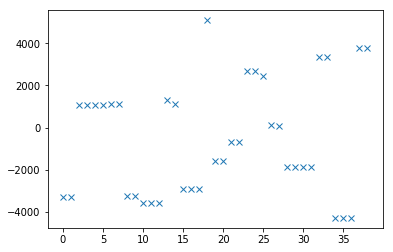

In [8]:
plt.plot(range(len(square_points)),square_points['scan_angle'],'x')

In [16]:
print("Avg point distance from plane: {:2.5f}".format(abs(square_points['dist_from_plane']).mean()))
print("Avg point distance from flat plane: {:2.5f}".format(abs(square_points['dist_from_flat']).mean()))

Avg point distance from plane: 0.02734
Avg point distance from flat plane: 0.03926


In [10]:
norm_vector

array([0.00497444, 0.00858148, 0.99995081])

y=0.00047631x+-0.00677393


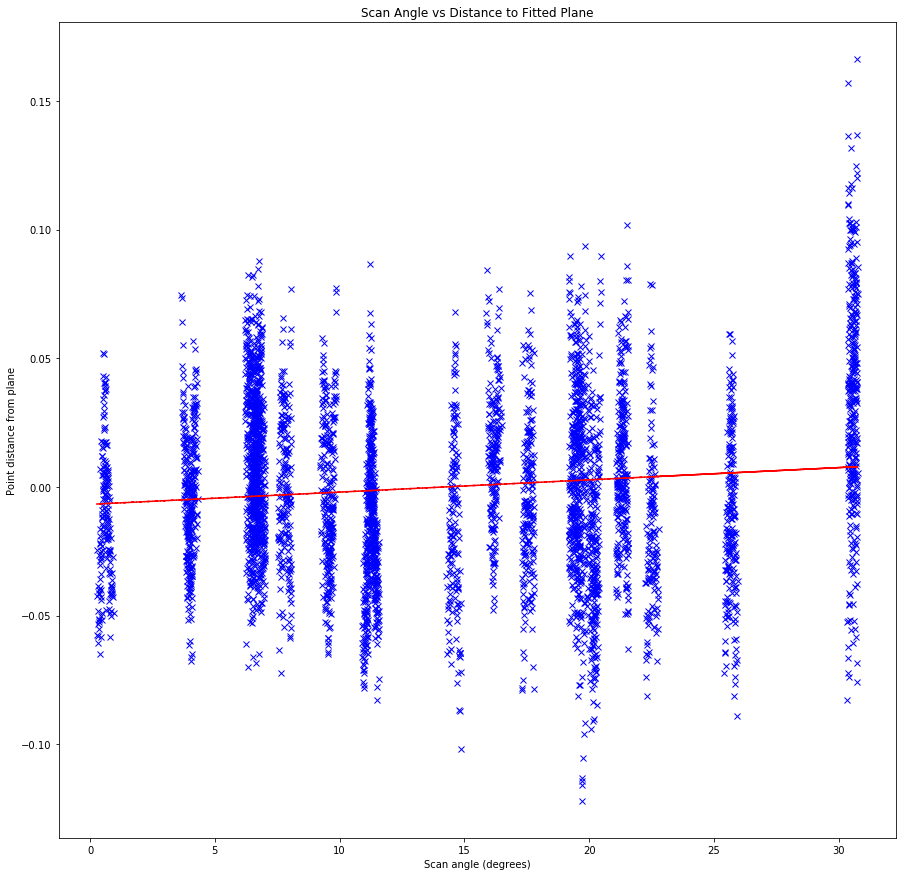

In [17]:
def plot_scan_angle_dist_from_plane(df,distance_metric):
    x = abs(df['scan_angle'])*.006
    y = df[distance_metric]
    plt.figure(figsize=(15,15))
    plt.plot(x,y,'xb')
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.xlabel("Scan angle (degrees)")
    plt.ylabel("Point distance from plane")
    print("y={:2.8f}x+{:2.8f}".format(z[0],z[1]))
    plt.title("Scan Angle vs Distance to Fitted Plane")
plot_scan_angle_dist_from_plane(square_points,'dist_from_plane')

y=0.00054665x+-0.00777427


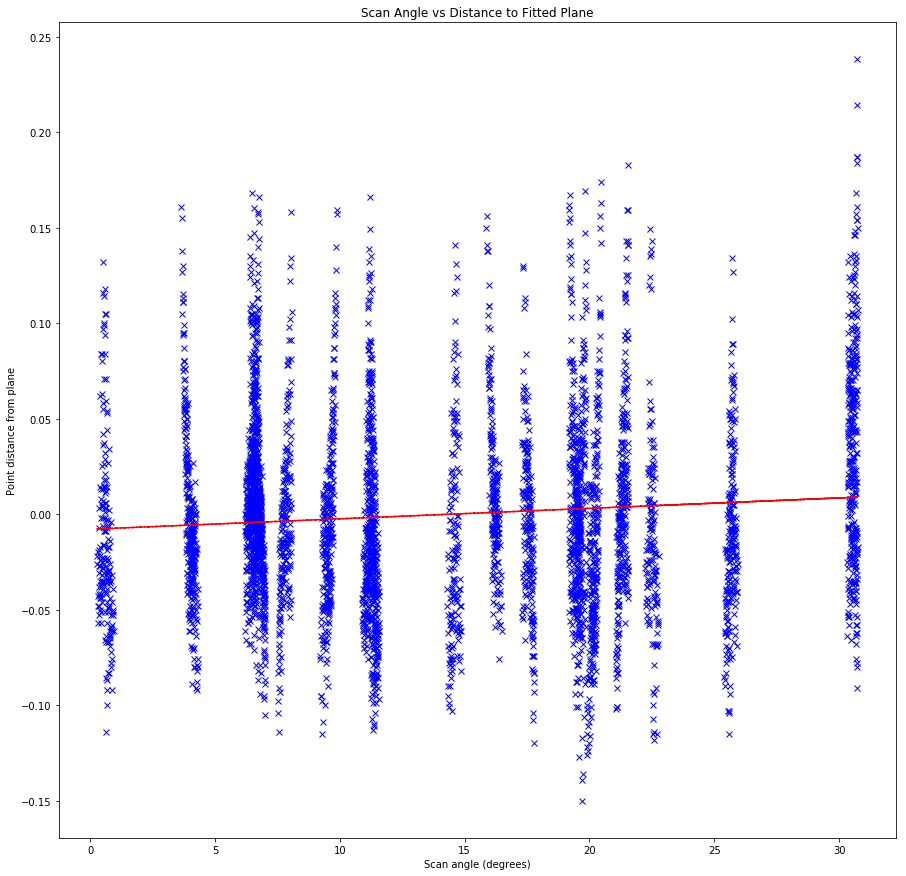

In [18]:
plot_scan_angle_dist_from_plane(square_points,'dist_from_flat')

In [25]:
las_points['gps_time'].min()

72249.06632943501

In [26]:
#200439
p = 590631.066332 / (60*60)
l = 72249.06632943501 / (60*60)
#old
# p = 578561.662519 / (60*60)
# l = 60179.662206 / (60*60)

In [27]:
p-144

20.064185092222203

In [28]:
l

20.069185091509723